## Importing Libraries

In [1]:
from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame
import numpy as np
import pandas as pd
import math

## Generating 2D  classification dataset

In [2]:
noise=0.01
X, y = make_moons(n_samples=100, noise=noise)
for i in range(9):
    noise+=0.01
    _X, _Y = make_moons(n_samples=100, noise=noise)
    X = np.concatenate((X, _X))
    y = np.concatenate((y, _Y))

## Visualizing the 10 different pairs of so-called moons

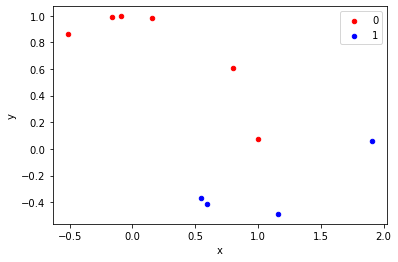

In [3]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0][:10], y=X[:,1][:10], label=y[:10]))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

## Function to split the dataset in train, validate and test set.

In [4]:
def split(df):
    
    X = df
    X_copy = X.copy()
    train = X_copy.sample(frac=0.70, random_state=0)
    test = X_copy.drop(train.index)
    test_copy = test.copy()
    test = test_copy.sample(frac=0.50, random_state=0)
    validate = test_copy.drop(test.index)
    
    return train, validate , test

## Function to convert the numeric label to categorical

In [5]:
### This function make 4 bins of column data and convert them to categorical data accordingly.
### Here a -- represents -- => values ranges from 0 to 25 % of mean of column <= --
### Here b -- represents -- => values ranges from 25 to 50 % of mean of column <= --
### Here c -- represents -- => values ranges from 50 to 75 % of mean of column <= --
### Here d -- represents -- => values ranges from 75 to 100 % of mean of column <= --

def label(val, *boundaries):
    if (val < boundaries[0]):
        return 'a'
    elif (val < boundaries[1]):
        return 'b'
    elif (val < boundaries[2]):
        return 'c'
    else:
        return 'd'

def toLabel(df, old_feature_name):
    second = df[old_feature_name].mean()
    minimum = df[old_feature_name].min()
    first = (minimum + second)/2
    maximum = df[old_feature_name].max()
    third = (maximum + second)/2
    return df[old_feature_name].apply(label, args= (first, second, third))

## Function to calculate gain

In [6]:
def calculate_gain(data):
    gn_sqr = sum(data['gn'])**2
    hn_lambda = sum(data['hn']) + 1
    return (-0.5*(gn_sqr/hn_lambda)) + 1

## Function to calculate individual gain of single feature column

In [7]:
def calculate_error(data,s_feature,target_feature):
    errors=[] # calculate gain of each unique value in given feature column and return max gain of the feature column
    vals = np.unique(data[s_feature])
    for val in vals:
        ys = data[data[s_feature]==val]
        ns = data[data[s_feature]!=val]
        
        error_ys = calculate_gain(ys)
        error_ns = calculate_gain(ns)
        all_error = calculate_gain(data)
        
        
        total_Erros = all_error - error_ys + error_ns
        errors.append(total_Erros)
    
    return np.max(errors)
        

## Function to calculate sigmoid 

In [8]:
def sigmoid(x):
    return 1 /(1+(math.e**-x))

## Function to calculate weight at leaf nodes

In [9]:
def calculate_weight(data):
    
    sm = sum(data['gn'])/(sum(data['hn'])+1)
    return -1*(sm)

## Function that builds tree and perform split using gain as split criteria

In [10]:
def DT(data,originaldata,features,target_feature="target",parent=None,level=0): 
    
 
    if (len(np.unique(data[target_feature])) <= 1):# checking if all the values are same if yes then we reached at a leaf
        
        elements,counts = np.unique(data[target_feature],return_counts = True)
        print('Level ',level)
        if elements ==0 :
            print('Count of 0 =',np.sum(counts))
        elif elements ==1 :
            print('Count of 1 =',np.sum(counts))
        print('Reached Leaf Node ')
        print()
        return calculate_weight(data)
    
    elif len(data) == 0:# checking the data is empty or not
        return calculate_weight(data)
    
    elif len(features) == 0:
        return calculate_weight(data)
    
    elif level==2: # check if max dept of tree is reached or not
        return calculate_weight(data)
    
    else :

        P_node = np.unique(data[target_feature])# put all the uniqe values of target in parent node
        
        values = []
        for ftr in features : # loop over all the features
            v = calculate_error(data,ftr,target_feature)# getting list of information gain of all features
            values.append(v)
        
        best_feature_index = np.argmax(values) # taking out the index of the feature which contains max information gain
        best_feature = features[best_feature_index]
        
        
        tree = {best_feature:{}}# I have used dictionaries to show my actual tree
        
        elements,counts = np.unique(data[target_feature],return_counts = True) #Print count of each class at each level
        print('Level ',level)                                      
        for i in range(len(elements)):
            if elements[i]==0 :
                print('count of 0  =',counts[i])
            elif elements[i]==1 :
                print('count of 1  =',counts[i])
            elif elements[i]==2 :
                print('count of 2  =',counts[i])
      
        print('Splitting on feature ',best_feature,' with gain ', values[best_feature_index])
        
        print()

        new_features = features                     
        features=[]
        for i in new_features : #remove the feature from feature list after split                                        
            if i != best_feature :                  
                features.append(i)
        level += 1       
        new_features=None           
        
        for vals in np.unique(data[best_feature]):   #   recursion of all diffrent values in that splitting feature
            
            value = vals
            sub_data = (data[data[best_feature] == value]).dropna()
            
            subtree = DT(sub_data,data,features,target_feature,P_node,level)
            tree[best_feature][value] = subtree
            
        return tree 

## Function to get tree prediction

In [11]:
def myprint(d, sr,val):
    keys = []
    vals = []
    
    for k, v in d.items():
        if isinstance(v, dict):
            keys=k
            vals = v
    
    if val is 3:
        key = list(d.keys())[0]
        fn = d[key][sr[key]]
        return fn
        
    if bool(keys):
        vl = sr[keys]
        valordict = vals[vl]
        
        if isinstance(valordict, dict):
            return myprint(valordict, sr, val=val+1)
        else:
            return valordict

## Function to find accuracy based on predictions

In [12]:
def find_accuracy(model_predict,actual_predict):
    correct = 0
    for i,j in zip(model_predict, actual_predict):
        if i==j:
            correct+=1
    return correct/len(model_predict)

## Main Function

In [13]:
def main_function(X,y):
    
    ### Convert Feature matric to dataframe
    df = pd.DataFrame(X)
    df.columns = ["x1_unlabeled", "x2_unlabeled"]
    y = pd.DataFrame(y)
    y.columns = ['target']


    ### Convert all columns to labelled data
    df['x1'] = toLabel(df, 'x1_unlabeled')
    df['x2'] = toLabel(df, 'x2_unlabeled')

    df.drop(['x1_unlabeled', 'x2_unlabeled'], axis = 1, inplace = True)    
    df['target']=y # addinge target column in the dataset

    ### split the dataset into train,test,validate sets
    train, validate, test = split(df)
    train_copy,validate_copy,test_copy =  train.copy(), validate.copy(), test.copy() 

    ### Add columns in train data as done by algorithm described in slides
    train['predict'] = 0
    train['sigmoidPredict']=1 / (1 + np.exp(-train['predict']))
    train['gn']=train['sigmoidPredict']-train['target']
    train['hn']=(train['sigmoidPredict'])*(1-train['sigmoidPredict'])
    tree = []
    
    ### Now we build multiple emsemble of trees with different number of trees in each ensemble
    for i in range(1, 7):
        print("###### Ensembling Tree Started with number of trees used:",i, "#########")

        for j in range(i):
            print("######## -- Building Tree: ",j+1, "#######################################")

            tree = DT(train, train, train.columns[:2]) # create tree based on algorithm described in slides 

            for index, row in train.iterrows(): # add weight of new tree to training data predict column
                predict_new = myprint(tree, row,0)
                train.loc[index, 'predict']= train.loc[index, 'predict'] + predict_new
                
            train['sigmoidPredict']=1 / (1 + np.exp(-train['predict'])) ### update certain columns as described in slides
            train['gn']=train['sigmoidPredict']-train['target']
            train['hn']=(train['sigmoidPredict'])*(1-train['sigmoidPredict'])
            print("##########--Tree Build: ",j+1, " Ended --##################################\n")

        print("########### Ensembling Trees Ended- ##################################")
        
        ans = [] ### Testing ensembled tree on validation set
        try:
            for index, row in validate.iterrows():
                sw = myprint(tree, row,0)
                ans.append(sw)
        except:
            ans.append(1)

        model_predict= [0 if x <= 0.5  else 1 for x in ans]
        actual_predict = validate['target']

        print("\n#########################---------------------------##################")
        print("Accuracy: " ,find_accuracy(model_predict,actual_predict), "with number of tree used: ", i)
        print("#########################---------------------------##################\n")
        print("\n#######################--------Now will test with different tree ensemble size---------################\n\n")

        ### For new ensemble reset all the columns values 
        train = train_copy 
        train['predict'] = 0
        train['sigmoidPredict']=1 / (1 + np.exp(-train['predict']))
        train['gn']=train['sigmoidPredict']-train['target']
        train['hn']=(train['sigmoidPredict'])*(1-train['sigmoidPredict'])
        
        
        
############--- Do Prediction on Test set using best ensembled tree with minimum validation error ---#############
    
    res = []
    try:
        for index, row in test.iterrows():
            sw = myprint(tree, row,0)
            res.append(sw)
    except:
        res.append(0)

    model_predict= [0 if sigmoid(x) < 0.5  else 1 for x in res]
    actual_predict = test['target']
    test_accuracy = find_accuracy(model_predict,actual_predict)
    
############--- Do Prediction on Test set using best ensembled tree with minimum validation error ---#############

    return test_accuracy

#### Run above main function to get accuracy of best ensembled tree on test set 

In [14]:
test_set_accuracy = main_function(X,y)

###### Ensembling Tree Started with number of trees used: 1 #########
######## -- Building Tree:  1 #######################################
Level  0
count of 0  = 344
count of 1  = 356
Splitting on feature  x2  with gain  63.209708079444916

Level  1
Count of 1 = 191
Reached Leaf Node 

Level  1
count of 0  = 65
count of 1  = 98
Splitting on feature  x1  with gain  19.988423779400446

Level  2
Count of 0 = 26
Reached Leaf Node 

Level  2
Count of 1 = 47
Reached Leaf Node 

Level  2
Count of 0 = 39
Reached Leaf Node 

Level  2
Count of 1 = 51
Reached Leaf Node 

Level  1
count of 0  = 115
count of 1  = 67
Splitting on feature  x1  with gain  21.123645665514736

Level  2
Count of 0 = 57
Reached Leaf Node 

Level  2
Count of 0 = 57
Reached Leaf Node 

Level  2
Count of 1 = 36
Reached Leaf Node 

Level  1
Count of 0 = 164
Reached Leaf Node 

##########--Tree Build:  1  Ended --##################################

########### Ensembling Trees Ended- ##################################

######

### Above results show that ensemble with 1 tree give us the highest accuracy on validation set. So I used  that tree and did prediction on test set 

### Test Accuracy

In [15]:
print("Test Accuracy: ", test_set_accuracy)

Test Accuracy:  1.0
